# Team Ecologists
### Museum Data processing

This notebook processes the raw dataset from Museum

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

from io import StringIO

In [7]:
data = pd.read_csv('spipoll_export_202012301551.txt', delimiter="\t")
data.head()

,URL,YMD,Lat,Long,Flower,collection,user_id,B&W_taxonomy,Nom_taxon,ORDRE,IFOR,SPFM,FM
0,https://spgp-api.65mo.fr/api/containers/spgp/d...,2019-06-12,45.363808,6.514947,Les Trèfles ? fleurs blanches ou roses en boul...,1,12657,Bees,L'Abeille mellifère (Apis mellifera),Hymenoptera,NaN,Apoidea,Apidae
1,https://spgp-api.65mo.fr/api/containers/spgp/d...,2019-06-12,45.363808,6.514947,Les Trèfles ? fleurs blanches ou roses en boul...,1,12657,Bees,Les Bourdons noirs à bande(s) jaune(s) et cul ...,Hymenoptera,NaN,Apoidea,Apidae
2,https://spgp-api.65mo.fr/api/containers/spgp/d...,2019-06-20,48.844975,2.358313,Acanthus mollis,2,10918,Bees,Les Bourdons noirs à bande(s) jaune(s) et cul ...,Hymenoptera,NaN,Apoidea,Apidae
3,https://spgp-api.65mo.fr/api/containers/spgp/d...,2019-06-20,48.844975,2.358313,Acanthus mollis,2,10918,Bees,L'Abeille mellifère (Apis mellifera),Hymenoptera,NaN,Apoidea,Apidae
4,https://spgp-api.65mo.fr/api/containers/spgp/d...,2019-06-12,44.711017,4.568069,"Les Orchidées ? fleurs blanches, jaunes ou ver...",3,11784,Other insects,Les Sauterelles (Tettigoniidae),Orthoptera,NaN,Tettigonioidea,Tettigoniidae


**Replacing class labels to match Kaggle Data**

In [42]:
data['B&W_taxonomy'] = data['B&W_taxonomy'].replace("Bees","bee")
data['B&W_taxonomy'] = data['B&W_taxonomy'].replace("Wasps","wasp")
data['B&W_taxonomy'] = data['B&W_taxonomy'].replace("Other insects","insect")
data['B&W_taxonomy'] = data['B&W_taxonomy'].replace("butterflies","butterfly")

In [43]:
data['B&W_taxonomy'].value_counts()

insect       175001
bee           74413
butterfly     29376
wasp          10796
Name: B&W_taxonomy, dtype: int64

**Processing a subset of data**

In [8]:
image_paths =  data.index < 1000
sub_data = data[image_paths]

1000 -> 3minutes

**Loading images**

In [11]:
from skimage import io

images = []

for path in sub_data['URL']:
    images.append(io.imread(path))

In [12]:
labels = []
for label in sub_data['B&W_taxonomy']:
    labels.append(label)

Now we have all the pictures in images & labels

**Removing bad images**

In [13]:
bad_images = []

for i in range(0,len(images)):
    shape = np.shape(images[i])
    if(len(shape)==2 or shape[2] != 3):
        bad_images.append(i)

No strange images among the first 1000

In [14]:
def perfect_resize(img):
    x = np.shape(img)
    
    diff = np.abs(x[0] - x[1])
    a = int(diff/2)
    
    if(len(x) == 3):
        if (x[0] < x[1]):
            b = int(x[1]-(diff/2))
            res = img[:,a:b,:]
        else:
            b = int(x[0]-(diff/2))
            res = img[a:b,:,:]
    else:
        if (x[0] < x[1]):
            b = int(x[1]-(diff/2))
            res = img[:,a:b]
        else:
            b = int(x[0]-(diff/2))
            res = img[a:b,:]
        
    return res

In [15]:
images_resized=[]
for i in range(0,np.shape(images)[0]):
    images_resized.append(perfect_resize(images[i]))

C:\Users\Thibaut\anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Now we check if all images are squared images :

In [16]:
for i in range(0,len(images_resized)):
    if(np.shape(images_resized[i])[0] != np.shape(images_resized[i])[1]):
        print(np.shape(images_resized[0])[0],np.shape(images_resized)[1])
        print("Erreur, des images ont mal été modifiés :" , i)

In [17]:
mini = 64

So we reduced all images with this size :

In [18]:
for i in range(0,len(images_resized)):
#     if (images_resized[i].dtype != images_resized[0].dtype):
#         images_resized[i] = (img[i]*255).astype(img[0].dtype)
    temp = Image.fromarray(images_resized[i])
    images_resized[i] = np.array(temp.resize(size=(mini, mini)))

In [19]:
for i in range(0,len(images_resized)):
    if (np.shape(images_resized[i])[0] != mini) or (np.shape(images_resized[i])[1] != mini) or (np.shape(images_resized[i])[2] != 3):
        print('Error')

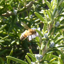

In [20]:
Image.fromarray(images_resized[592])

Now we will flatten the array to insert it into the dataframe :

In [21]:
for i in range(0,len(images_resized)):
    images_resized[i] = images_resized[i].ravel()

In [22]:
for i in range(0,len(images_resized)):
    if (np.shape(images_resized[i])[0] != mini*mini*3):
        print('Error',i)

Now we will convert the array img into a dataframe :

In [23]:
column = []
for i in range(0,mini*mini):
    name = 'pixel_'+str(1+int(i/mini))+'_'+str(1+(i%mini))
    column.append(name+'_R')
    column.append(name+'_G')
    column.append(name+'_B')

In [24]:
image_resized_DF = pd.DataFrame(columns = column, data=images_resized)

In [25]:
labels_DF = pd.DataFrame(columns=['label'], data=labels)

In [26]:
merged = image_resized_DF.merge(labels_DF, left_index=True, right_index=True)

In [27]:
merged.to_csv(r'C:/Users/Thibaut/Desktop/FAC/M1 - DS/T3/ProjectA/dataMuseum1000.csv',index=False)

---------------------------

## Creating a subset of the dataset with 500 images from each class

In [55]:
bees = data[data["B&W_taxonomy"] == "bee"]
bees = bees.reset_index()
butterflies = data[data["B&W_taxonomy"] == "butterfly"]
butterflies = butterflies.reset_index()
wasps = data[data["B&W_taxonomy"] == "wasp"]
wasps = wasps.reset_index()
other_insects = data[data["B&W_taxonomy"] == "insect"]
other_insects = other_insects.reset_index()

In [56]:
size = 500

sub_data_bees = bees[bees.index < size]
sub_data_butterflies = butterflies[butterflies.index < size]
sub_data_wasps = wasps[wasps.index < size]
sub_data_other_insects = other_insects[other_insects.index < size]

In [91]:
images = []
labels = []

for index in range(size):
    images.append(io.imread(sub_data_bees["URL"].iloc[index]))
    images.append(io.imread(sub_data_butterflies["URL"].iloc[index]))
    images.append(io.imread(sub_data_wasps["URL"].iloc[index]))
    images.append(io.imread(sub_data_other_insects["URL"].iloc[index]))
    
    labels.append("bee")
    labels.append("butterfly")
    labels.append("wasp")
    labels.append("insect")

In [100]:
for i in range(0,len(images)):
    shape = np.shape(images[i])
    if(len(shape)==2 or shape[2] != 3):
        images.pop(i)
        labels.pop(i)
        print(i)

In [101]:
images_resized=[]
for i in range(0,np.shape(images)[0]):
    images_resized.append(perfect_resize(images[i]))

Now we check if all images are squared images :

In [102]:
for i in range(0,len(images_resized)):
    if(np.shape(images_resized[i])[0] != np.shape(images_resized[i])[1]):
        print(np.shape(images_resized[0])[0],np.shape(images_resized)[1])
        print("Erreur, des images ont mal été modifiés :" , i)

In [103]:
mini = 64

So we reduced all images with this size :

In [104]:
for i in range(0,len(images_resized)):
#     if (images_resized[i].dtype != images_resized[0].dtype):
#         images_resized[i] = (img[i]*255).astype(img[0].dtype)
    temp = Image.fromarray(images_resized[i])
    images_resized[i] = np.array(temp.resize(size=(mini, mini)))

In [105]:
for i in range(0,len(images_resized)):
    if (np.shape(images_resized[i])[0] != mini) or (np.shape(images_resized[i])[1] != mini) or (np.shape(images_resized[i])[2] != 3):
        print(np.shape(images_resized[i]))

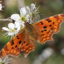

In [106]:
Image.fromarray(images_resized[592])

Now we will flatten the array to insert it into the dataframe :

In [107]:
for i in range(0,len(images_resized)):
    images_resized[i] = images_resized[i].ravel()

In [108]:
for i in range(0,len(images_resized)):
    if (np.shape(images_resized[i])[0] != mini*mini*3):
        print('Error',i)

Now we will convert the array img into a dataframe :

In [109]:
column = []
for i in range(0,mini*mini):
    name = 'pixel_'+str(1+int(i/mini))+'_'+str(1+(i%mini))
    column.append(name+'_R')
    column.append(name+'_G')
    column.append(name+'_B')

In [110]:
image_resized_DF = pd.DataFrame(columns = column, data=images_resized)

In [111]:
labels_DF = pd.DataFrame(columns=['label'], data=labels)

In [112]:
merged = image_resized_DF.merge(labels_DF, left_index=True, right_index=True)

In [113]:
merged.to_csv(r'C:/Users/Thibaut/Desktop/FAC/M1 - DS/T3/ProjectA/dataMuseum500each.csv',index=False)

In [114]:
data_500_each = pd.read_csv('dataMuseum500each.csv')

In [116]:
data_500_each.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1999 entries, 0 to 1998
Columns: 12289 entries, pixel_1_1_R to label
dtypes: int64(12288), object(1)
memory usage: 187.4+ MB
